<img src='./img/EU-Copernicus-EUM_3Logos.png' alt='Logo EU Copernicus EUMETSAT' align='right' width='50%'></img>

<br>

<a href="./23_ltpy_v01_Sentinel5p_L2_data.ipynb"><< 23 - Copernicus Sentinel-5 Precursor (Sentinel-5P) </a>&nbsp;<space>&nbsp;<space>&nbsp;<space>&nbsp;<space>&nbsp;<space>&nbsp;<space>&nbsp;<space>&nbsp;<space>&nbsp;<space>&nbsp;<space> <a href="./32_ltpy_v01_AC_SAF_L3_case_study.ipynb">32 - AC SAF Level 3 - Workflow examples >></a>

# 3.1 AC SAF Level 2 - Case studies

AC SAF GOME-2 Level 2 and Copernicus  data are helpful to track and monitor inputs to the atmosphere from various trace gases.

We investigate two case studies:
* **[1) Case study - Amazonian fires and the spread of HCHO in August 2019](#amazon_fires)**
 * [1.1 - Load AC SAF Level 2 HCHO data for 19 and 22 August 2019](#amazon_fires_1)
 * [1.2 - Plot AC SAF Level 2 HCHO data - Mollweide projection](#amazon_fires_2)
 * [1.3 - Generate a geographical subset over South America and plot the subset](#amazon_fires_3)
 * [1.4 - Integrate with Sentinel-5P CO data](#amazon_fires_4)
* **[2) Case study - Canada / US fires in August 2018](#us_fires)**
 * [2.1 - Generate a geographical subset of a masked Metop-A and Metop-B combined dataset](#us_fires_1)
 * [2.2 - Plot the three geographical subsets in one row](#us_fires_2)
 * [2.3 - Integrate with Sentinel-5P CO data](#us_fires_3)

<hr>

#### Load required libraries

In [1]:
import os
import h5py
import xarray as xr
import numpy as np

from matplotlib import pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import warnings
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

#### Helper functions

In [2]:
def load_l2_data_xr(directory, internal_filepath, parameter, longname, unit, name):
    fileList = os.listdir(directory)
    datasets = []

    for i in fileList:
        fullpath=os.path.join(directory, i)
        tmp = h5py.File(fullpath, 'r')
        groups =tmp.keys()
        tmp[internal_filepath]
        latitude = tmp['GEOLOCATION/LatitudeCentre']
        longitude = tmp['GEOLOCATION/LongitudeCentre']
        param = tmp[internal_filepath+'/'+parameter]
        da_tmp = xr.DataArray(
            param[()],
            dims=('ground_pixel'),
            coords={
                'latitude': ('ground_pixel', latitude[:]),
                'longitude': ('ground_pixel', longitude[:])
            },
            attrs={'long_name': longname, 'units': unit},
            name=name
        )
        datasets.append(da_tmp)

    return xr.concat(datasets, dim='ground_pixel')

In [3]:
def visualize_gome_mollweide(xr_dataarray, conversion_factor, color_scale, vmin, vmax):
    fig, ax = plt.subplots(figsize=(40, 10))
    ax = plt.axes(projection=ccrs.Mollweide())

    ax.coastlines()
    ax.set_global()

    ax.gridlines(linestyle='--')
    # plot pixel positions
    img = ax.scatter(
        xr_dataarray.longitude.data,
        xr_dataarray.latitude.data,
        c=xr_dataarray.data*conversion_factor,
        cmap=plt.cm.get_cmap(color_scale),
        marker='o',
        s=0.5,
        transform=ccrs.PlateCarree(),
        vmin=vmin,
        vmax=vmax
    )

    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel("Longitude", fontsize=16)
    plt.ylabel("Latitude", fontsize=16)
    cbar = fig.colorbar(img, ax=ax, orientation='horizontal', fraction=0.04, pad=0.1)
    cbar.set_label(xr_dataarray.units, fontsize=16)
    cbar.ax.tick_params(labelsize=14)
    ax.set_title(xr_dataarray.long_name, fontsize=20, pad=20.0)
    plt.show()

In [4]:
def visualize_gome_l2(xr_dataarray, conversion_factor, projection, color_scale, vmin, vmax, set_global=False):
    fig, ax = plt.subplots(figsize=(40, 10))
    ax = plt.axes(projection=projection)

    ax.coastlines()
    if set_global:
        ax.set_global()
    # set gridlines
#    ax.gridlines()
    gl = ax.gridlines(draw_labels=True, linestyle='--')
    gl.xlabels_top=False
    gl.ylabels_right=False
    gl.xformatter=LONGITUDE_FORMATTER
    gl.yformatter=LATITUDE_FORMATTER
    
    gl.xlabel_style={'size':14}
    gl.ylabel_style={'size':14}

    # plot pixel positions
    img = ax.scatter(
        xr_dataarray.longitude.data,
        xr_dataarray.latitude.data,
        c=xr_dataarray.data*conversion_factor,
        cmap=plt.cm.get_cmap(color_scale),
        marker='o',
        s=0.5,
        transform=ccrs.PlateCarree(),
        vmin=vmin,
        vmax=vmax
    )

    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel("Longitude", fontsize=16)
    plt.ylabel("Latitude", fontsize=16)
    cbar = fig.colorbar(img, ax=ax, orientation='horizontal', fraction=0.04, pad=0.1)
    cbar.set_label(str(conversion_factor) + ' ' + xr_dataarray.units, fontsize=16)
    cbar.ax.tick_params(labelsize=14)
    ax.set_title(xr_dataarray.long_name, fontsize=20, pad=20.0)
    plt.show()

In [5]:
def generate_geographical_subset(xarray, latmin, latmax, lonmin, lonmax):
    xarray = xarray.assign_coords(longitude=(((xarray.longitude + 180) % 360) - 180))
    return xarray.where((xarray.latitude < latmax) & (xarray.latitude > latmin) & (xarray.longitude < lonmax) & (xarray.longitude > lonmin),drop=True)

In [6]:
def generate_masked_array(xarray, mask, threshold):
    cloud_mask = xr.where(mask < threshold, 1, 0)
    xarray_masked = xr.where(cloud_mask ==1, xarray, 0)
    xarray_masked.attrs = xarray.attrs
    return xarray_masked[xarray_masked > 0]

In [7]:
def load_masked_l2_da(directory, internal_filepath, parameter, longname, unit, name, threshold):
    da = load_l2_data_xr(directory, internal_filepath, parameter, longname, unit, name)
    cloud_fraction = load_l2_data_xr(directory, 'CLOUD_PROPERTIES', 'CloudFraction', '-', 'Cloud Fraction', 'cloud_fraction')
    
    return generate_masked_array(da, cloud_fraction, threshold)

<hr>

## <a ref="amazon_fires"></a>1) Case study -  Amazonian fires and the spread of `HCHO` in August 2019

Satellite data show the large input to atmosphere due to Amazonian fires. GOME-2 is capable to measure the total amount of `Formaldehyde (HCHO)` over a specific pixel. Nevertheless, since `HCHO` is concentrated close to surface, due to its volatility and reactivity, these observations are indicatives of the location and intensity of the sources.

`HCHO` is a precursor (e.g. serves as basis for multiple reactions including ones producing tropospheric ozone) and is considered harmful due to its toxicity and volatility.
`HCHO` is produced both by synthesis and natural reactions. [Biomass burning](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/1999GL900156) is considered to be a significant organic source of `HCHO`.

We can monitor Formaldehyde from GOME-2 instrument onboard Metop-B between 18 and 22 August 2019. Let's compare Formaldehyde between 18 August and 22 August 2019.

### <a id="amazon_fires_1"></a>1) Load AC SAF Level 2 `HCHO` data for 19 and 22 August 2019

Define general variables that facilitate the loading of the data

In [33]:
parameter='HCHO'

internal_filepath='TOTAL_COLUMNS'

longname='Vertical column density of ' + parameter
unit='mol/cm2'
name='vertical_column_' + parameter
threshold = 0.3

latmin = -60
latmax = 15
lonmin = -80
lonmax = 40

Load masked `HCHO` data with the help of `load_masked_l2_da` function. Do it for 18 August and subsequently for 22 August 2019.

In [34]:
day1 = '19'
directory_2a= './eodata/gome2/offline/2a/2019/08/'+day1+'/'
directory_2b= './eodata/gome2/offline/2b/2019/08/'+day1+'/'

gome_2a_1 = load_masked_l2_da(directory_2a, internal_filepath, parameter, longname, unit, name, threshold)
gome_2b_1 = load_masked_l2_da(directory_2b, internal_filepath, parameter, longname, unit, name, threshold)
ab_da_masked_1 = xr.concat([gome_2a_1, gome_2b_1], dim='ground_pixel')
ab_da_masked_1

<xarray.DataArray (ground_pixel: 113493)>
array([7.900601e+15, 3.443111e+15, 3.566854e+15, ..., 8.009807e+15,
       8.292620e+14, 1.506891e+14], dtype=float32)
Coordinates:
    latitude   (ground_pixel) float32 77.97622 79.2065 ... -46.82142 -47.16903
    longitude  (ground_pixel) float32 338.0256 332.85165 ... 347.78342 347.6936
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  Vertical column density of HCHO
    units:      mol/cm2

In [35]:
day2 = '22'
directory_2a= './eodata/gome2/offline/2a/2019/08/'+day2+'/'
directory_2b= './eodata/gome2/offline/2b/2019/08/'+day2+'/'

gome_2a_2 = load_masked_l2_da(directory_2a, internal_filepath, parameter, longname, unit, name, threshold)
gome_2b_2 = load_masked_l2_da(directory_2b, internal_filepath, parameter, longname, unit, name, threshold)
ab_da_masked_2 = xr.concat([gome_2a_2, gome_2b_2], dim='ground_pixel')
ab_da_masked_2

<xarray.DataArray (ground_pixel: 108969)>
array([1.917708e+15, 9.184570e+15, 5.441547e+14, ..., 5.705427e+15,
       7.862950e+15, 3.173010e+15], dtype=float32)
Coordinates:
    latitude   (ground_pixel) float32 77.98511 77.95698 ... -46.85387 -48.660007
    longitude  (ground_pixel) float32 293.77896 292.0571 ... 208.11317 211.04701
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  Vertical column density of HCHO
    units:      mol/cm2

<br>

### <a id="amazon_fires_2"></a>2) Plot AC SAF Level 2 `HCHO` data - Mollweide projection

Let's plot `HCHO` data for 18 August 2019. We see elevated `HCHO` values in Brazil, over the region of the Amazonas fires.

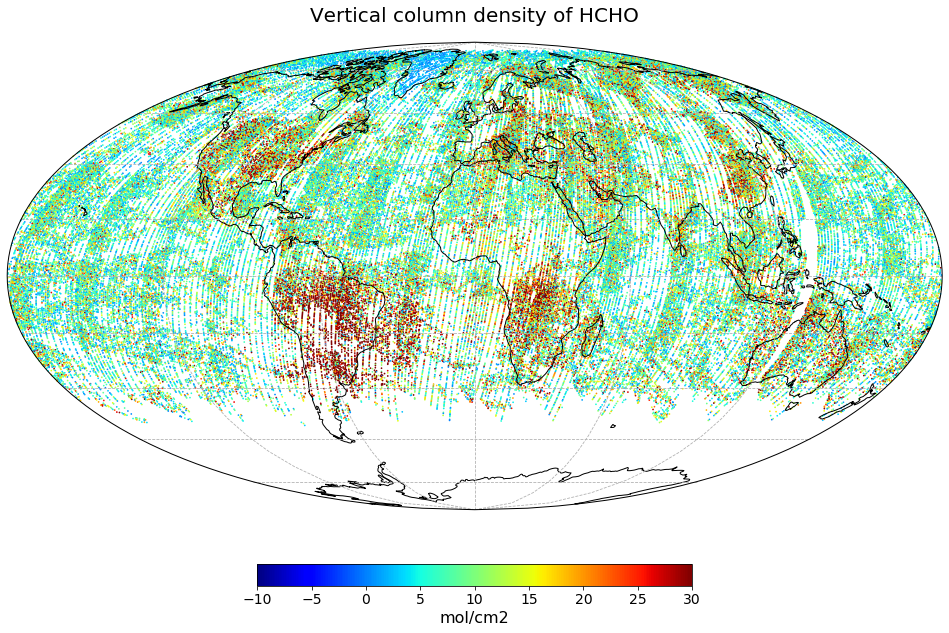

In [36]:
visualize_gome_mollweide(ab_da_masked_1, 1e-15, 'jet', -10, 30)

<br>

### <a id="amazon_fires_3"></a>3) Generate a geographical subset over South America and plot the subset

Generate a geographical subset for 19 August 2019, with the help of the `generate_geographical_subset` function.

In [37]:
ab_da_subset_1 = generate_geographical_subset(ab_da_masked_1, latmin, latmax, lonmin, lonmax)
ab_da_subset_1

<xarray.DataArray (ground_pixel: 16557)>
array([3.627289e+15, 1.272782e+16, 1.596670e+16, ..., 8.009807e+15,
       8.292620e+14, 1.506891e+14], dtype=float32)
Coordinates:
    latitude   (ground_pixel) float32 14.974978 14.691791 ... -47.16903
    longitude  (ground_pixel) float32 9.261887 10.438858 ... -12.3063965
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  Vertical column density of HCHO
    units:      mol/cm2

<br>

Generate a geographical subset for 22 August 2019.

In [38]:
ab_da_subset_2 = generate_geographical_subset(ab_da_masked_2, latmin, latmax, lonmin, lonmax)
ab_da_subset_2

<xarray.DataArray (ground_pixel: 16642)>
array([7.115530e+15, 2.270518e+15, 1.443459e+16, ..., 3.514058e+15,
       2.288526e+14, 9.229334e+14], dtype=float32)
Coordinates:
    latitude   (ground_pixel) float32 14.850608 14.666883 ... -45.11611 -48.3163
    longitude  (ground_pixel) float32 26.155579 26.859604 ... -22.165894
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  Vertical column density of HCHO
    units:      mol/cm2

<br>

Set some global variables that facilitate plotting and then plot both days next to each other.

In [39]:
day1 = '20190819'
day2 = '20190822'
conversion_factor = 1e-15
color_scale = 'gist_rainbow'
vmin = 0
vmax = 25



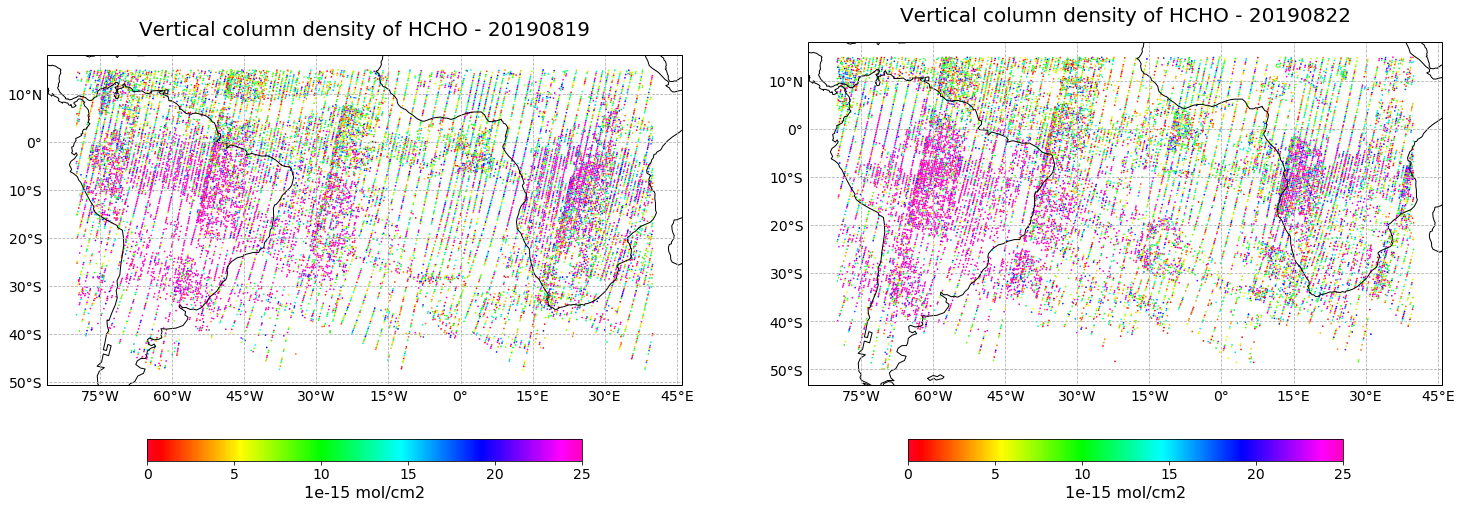

In [40]:
fig = plt.figure(figsize=(25,10))

#################################
# First subplot
#################################
ax1 = plt.subplot(1,2,1, projection=ccrs.PlateCarree())
ax1.coastlines()

gl = ax1.gridlines(draw_labels=True, linestyle='--')
gl.xlabels_top=False
gl.ylabels_right=False
gl.xformatter=LONGITUDE_FORMATTER
gl.yformatter=LATITUDE_FORMATTER
    
gl.xlabel_style={'size':14}
gl.ylabel_style={'size':14}

img1 = ax1.scatter(
    ab_da_subset_1.longitude.data,
    ab_da_subset_1.latitude.data,
    c=ab_da_subset_1.data*conversion_factor,
    cmap=plt.cm.get_cmap(color_scale),
    marker='o',
    s=0.5,
    transform=ccrs.PlateCarree(),
    vmin=vmin,
    vmax=vmax
    )
cbar = fig.colorbar(img1, ax=ax1, orientation='horizontal', fraction=0.04, pad=0.1)
cbar.set_label(str(conversion_factor) + ' ' + ab_da_subset_1.units, fontsize=16)
cbar.ax.tick_params(labelsize=14)
ax1.set_title(ab_da_subset_1.long_name + ' - ' + day1, fontsize=20, pad=20.0)

################################
# Start of second subplot
################################
ax2 = plt.subplot(1,2,2, projection=ccrs.PlateCarree())
ax2.coastlines()

gl = ax2.gridlines(draw_labels=True, linestyle='--')
gl.xlabels_top=False
gl.ylabels_right=False
gl.xformatter=LONGITUDE_FORMATTER
gl.yformatter=LATITUDE_FORMATTER
    
gl.xlabel_style={'size':14}
gl.ylabel_style={'size':14}

img2 = ax2.scatter(
    ab_da_subset_2.longitude.data,
    ab_da_subset_2.latitude.data,
    c=ab_da_subset_2.data*conversion_factor,
    cmap=plt.cm.get_cmap(color_scale),
    marker='o',
    s=0.5,
    transform=ccrs.PlateCarree(),
    vmin=vmin,
    vmax=vmax
    )
cbar = fig.colorbar(img2, ax=ax2, orientation='horizontal', fraction=0.04, pad=0.1)
cbar.set_label(str(conversion_factor) + ' ' + ab_da_subset_2.units, fontsize=16)
cbar.ax.tick_params(labelsize=14)
ax2.set_title(ab_da_subset_2.long_name + ' - ' + day2, fontsize=20, pad=20.0)

plt.show()

<br>

<br>

### 4) <a id="amazon_fires_4"></a>Integrate with Sentinel-5P `CO` data

Load `Sentinel-5P CO` data for 19 and 22 August 2019 and plot both data sets next to each other.

In [41]:
s5p_mf_19 = xr.open_mfdataset('./eodata/sentinel5p/co/2019/08/19/*.nc', concat_dim='scanline', combine='nested', group='PRODUCT')
s5p_mf_19

co_19 = s5p_mf_19.carbonmonoxide_total_column[0,:,:]
lat_19 = co_19.latitude
lon_19 = co_19.longitude

In [42]:
s5p_mf_22 = xr.open_mfdataset('./eodata/sentinel5p/co/2019/08/22/*.nc', concat_dim='scanline', combine='nested', group='PRODUCT')
s5p_mf_22

co_22 = s5p_mf_22.carbonmonoxide_total_column[0,:,:]

lat_22 = co_22.latitude
lon_22 = co_22.longitude

<br>

Plot both `DataArrays` in one row, with `subplot`.

In [45]:
lonmin=-100
lonmax=0
latmin=-80
latmax=40

color_scale = 'gist_rainbow'
vmin=0.00001
vmax=10

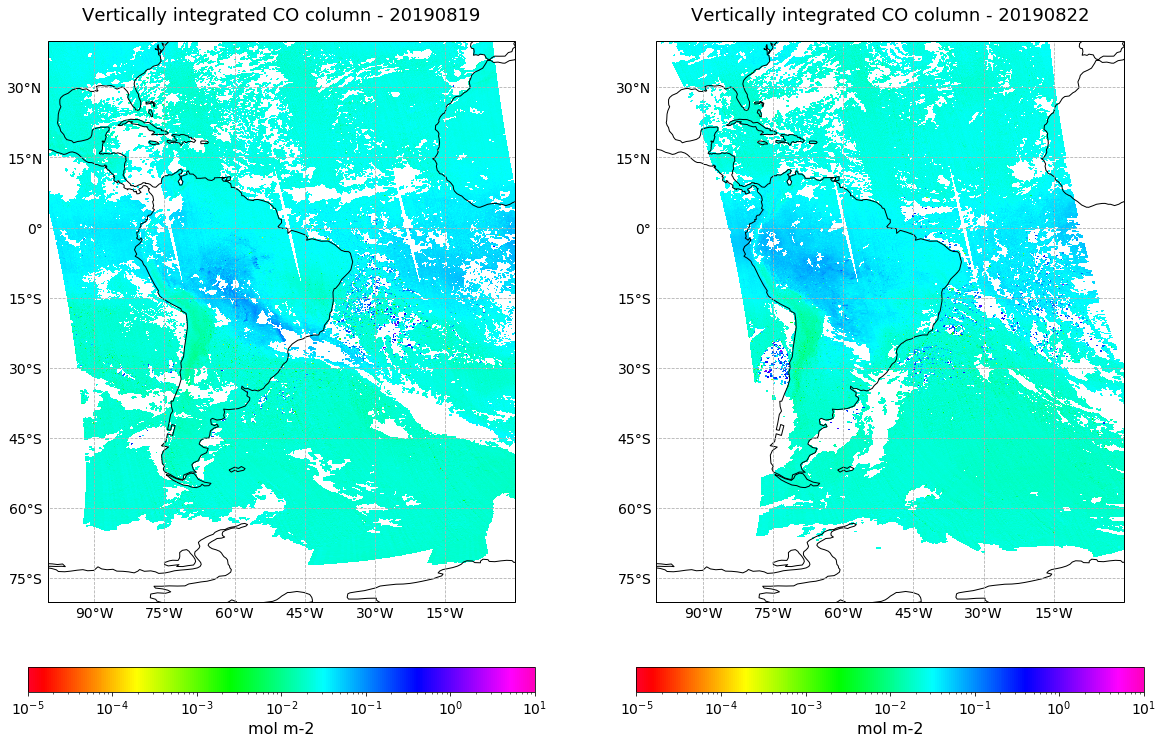

In [47]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import cartopy.crs as ccrs

fig=plt.figure(figsize=(20, 12))

################################
# Start of first subplot
################################
ax1 = plt.subplot(1,2,1, projection=ccrs.PlateCarree())

# define the coordinate system that the grid lons and grid lats are on
img1 = plt.pcolormesh(lon_19, lat_19, np.squeeze(co_19.data), norm=LogNorm(), cmap=plt.get_cmap(color_scale), transform=ccrs.PlateCarree(),vmin=vmin, vmax=vmax)
ax1.set_extent([lonmin, lonmax, latmin, latmax], ccrs.PlateCarree())
ax1.coastlines()

gl = ax1.gridlines(draw_labels=True, linestyle='--')
gl.xlabels_top=False
gl.ylabels_right=False
gl.xformatter=LONGITUDE_FORMATTER
gl.yformatter=LATITUDE_FORMATTER
    
gl.xlabel_style={'size':14}
gl.ylabel_style={'size':14}

cbar = fig.colorbar(img1, ax=ax1, orientation='horizontal', fraction=0.04, pad=0.1)
cbar.set_label(co_19.units, fontsize=16)
cbar.ax.tick_params(labelsize=14)
ax1.set_title(co_19.long_name + ' - ' + day1, fontsize=18, pad=20.0)

################################
# Start of second subplot
################################
ax2 = plt.subplot(1,2,2, projection=ccrs.PlateCarree())

# define the coordinate system that the grid lons and grid lats are on
img2 = plt.pcolormesh(lon_22, lat_22, np.squeeze(co_22.data), norm=LogNorm(), cmap=plt.get_cmap(color_scale), transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax)
ax2.set_extent([lonmin, lonmax, latmin, latmax], ccrs.PlateCarree())
ax2.coastlines()

gl = ax2.gridlines(draw_labels=True, linestyle='--')
gl.xlabels_top=False
gl.ylabels_right=False
gl.xformatter=LONGITUDE_FORMATTER
gl.yformatter=LATITUDE_FORMATTER
gl.xlabel_style={'size':14}
gl.ylabel_style={'size':14}

cbar = fig.colorbar(img2, ax=ax2, orientation='horizontal', fraction=0.04, pad=0.1)
cbar.set_label(co_22.units, fontsize=16)
cbar.ax.tick_params(labelsize=14)
ax2.set_title(co_22.long_name + ' - ' + day2, fontsize=18, pad=20.0)

plt.show()

<br>

<br>

## <a ref="us_fires"></a>2) Case study - Canada / US fires in August 2018

Between August 13-18 2018, smoke from wildfires in western US and Canada moved across the CONUS and reached the eastern US, including New England, on Aug 16-17 2018. Particulate Matter 2.5 e.g. increased to Code Yellow (Moderate) due to the smoke (much higher than normal).

We load AC SAF Level 2 `HCHO` data for three days (13, 16 and 18 August 2018) and compare the signal.

#### Define some general variables.

In [49]:
day1 = '20180813'
day2 = '20180816'
day3 = '20180818'

parameter='HCHO'
conversion_factor = 1e-15
color_scale='gist_rainbow'

longname='Vertical column density of ' + parameter
unit='mol/cm2'
name='vertical_column_ ' + parameter

vmin=0
vmax=20

<br>

### <a id="us_fires_1"></a>1) Generate a geographical subset of a masked Metop-A and Metop-B combined dataset

Load the data for the three days. For each day, we combine Metop-A and Metop-B data, mask them and generate a geographical subset that covers Canada and US.

In [50]:
directory_2b= './eodata/gome2/offline/2b/2018/08/13/'
directory_2a= './eodata/gome2/offline/2a/2018/08/13/'
no2_2b_13 = load_masked_l2_da(directory_2b, 'TOTAL_COLUMNS', parameter, longname, unit, 'vertical_column_HCHO',0.3)
no2_2a_13 = load_masked_l2_da(directory_2a, 'TOTAL_COLUMNS', parameter, longname, unit, 'vertical_column_HCHO',0.3)
no2_ab_concat_13 =  xr.concat([no2_2b_13, no2_2a_13], dim='ground_pixel')

no2_ab_13_subset = generate_geographical_subset(no2_ab_concat_13, latmin,latmax,lonmin,lonmax)
no2_ab_13_subset

<xarray.DataArray (ground_pixel: 16166)>
array([1.129430e+16, 2.309268e+15, 5.214314e+15, ..., 2.763243e+14,
       1.346112e+15, 3.688082e+15], dtype=float32)
Coordinates:
    latitude   (ground_pixel) float32 69.78127 69.984886 ... 20.325815 20.398817
    longitude  (ground_pixel) float32 -51.482178 -54.406464 ... -159.76294
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  Vertical column density of HCHO
    units:      mol/cm2

<br>

In [51]:
directory_2b= './eodata/gome2/offline/2b/2018/08/16/'
directory_2a= './eodata/gome2/offline/2a/2018/08/16/'

no2_2b_16 = load_masked_l2_da(directory_2b, 'TOTAL_COLUMNS', parameter, longname, unit, 'vertical_column_HCHO',0.3)
no2_2a_16 = load_masked_l2_da(directory_2a, 'TOTAL_COLUMNS', parameter, longname, unit, 'vertical_column_HCHO',0.3)
no2_ab_concat_16 =  xr.concat([no2_2b_16, no2_2a_16], dim='ground_pixel')

no2_ab_16_subset = generate_geographical_subset(no2_ab_concat_16, latmin,latmax,lonmin,lonmax)
no2_ab_16_subset

<xarray.DataArray (ground_pixel: 15133)>
array([2.750805e+15, 7.148302e+15, 8.472054e+15, ..., 2.532243e+15,
       7.392142e+15, 9.174637e+14], dtype=float32)
Coordinates:
    latitude   (ground_pixel) float32 69.69135 69.79311 ... 44.09201 43.639263
    longitude  (ground_pixel) float32 -50.349945 -53.896423 ... -159.84528
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  Vertical column density of HCHO
    units:      mol/cm2

<br>

In [52]:
directory_2b= './eodata/gome2/offline/2b/2018/08/18/'
directory_2a= './eodata/gome2/offline/2a/2018/08/18/'

no2_2b_18 = load_masked_l2_da(directory_2b, 'TOTAL_COLUMNS', parameter, longname, unit, 'vertical_column'+parameter,0.3)
no2_2a_18 = load_masked_l2_da(directory_2a, 'TOTAL_COLUMNS', parameter, longname, unit, 'vertical_column'+parameter,0.3)
no2_ab_concat_18 =  xr.concat([no2_2b_18, no2_2a_18], dim='ground_pixel')

no2_ab_18_subset = generate_geographical_subset(no2_ab_concat_18, latmin,latmax,lonmin,lonmax)
no2_ab_18_subset

<xarray.DataArray (ground_pixel: 15076)>
array([3.866392e+15, 3.997556e+15, 8.520685e+12, ..., 6.300478e+15,
       1.710771e+16, 2.019121e+16], dtype=float32)
Coordinates:
    latitude   (ground_pixel) float32 69.39912 69.15027 ... 20.35091 20.099648
    longitude  (ground_pixel) float32 -154.71796 -155.4574 ... -138.45572
Dimensions without coordinates: ground_pixel
Attributes:
    long_name:  Vertical column density of HCHO
    units:      mol/cm2

<br>

### <a id="us_fires_2"></a>2) Plot the three geographical subsets in one row

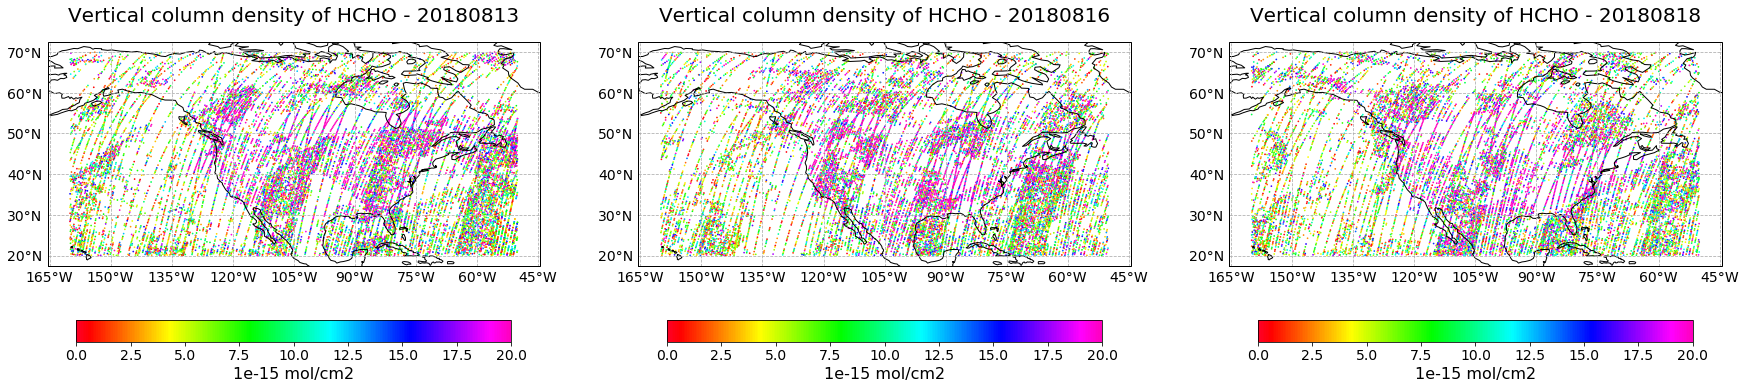

In [53]:
fig = plt.figure(figsize=(30,10))

#################################
# First subplot
##################################
ax1 = plt.subplot(1,3,1, projection=ccrs.PlateCarree())
ax1.coastlines()
gl = ax1.gridlines(draw_labels=True, linestyle='--')
gl.xlabels_top=False
gl.ylabels_right=False
gl.xformatter=LONGITUDE_FORMATTER
gl.yformatter=LATITUDE_FORMATTER
    
gl.xlabel_style={'size':14}
gl.ylabel_style={'size':14}

img1 = ax1.scatter(
    no2_ab_13_subset.longitude.data,
    no2_ab_13_subset.latitude.data,
    c=no2_ab_13_subset.data*conversion_factor,
    cmap=plt.cm.get_cmap(color_scale),
    marker='o',
    s=0.5,
    transform=ccrs.PlateCarree(),
    vmin=vmin,
    vmax=vmax
    )
cbar = fig.colorbar(img1, ax=ax1, orientation='horizontal', fraction=0.04, pad=0.1)
cbar.set_label(str(conversion_factor) + ' ' + no2_ab_13_subset.units, fontsize=16)
cbar.ax.tick_params(labelsize=14)
ax1.set_title(no2_ab_13_subset.long_name + ' - ' + day1, fontsize=20, pad=20.0)

#################################
# Second subplot
##################################
ax2 = plt.subplot(1,3,2, projection=ccrs.PlateCarree())
ax2.coastlines()

gl = ax2.gridlines(draw_labels=True, linestyle='--')
gl.xlabels_top=False
gl.ylabels_right=False
gl.xformatter=LONGITUDE_FORMATTER
gl.yformatter=LATITUDE_FORMATTER
    
gl.xlabel_style={'size':14}
gl.ylabel_style={'size':14}

img2 = ax2.scatter(
    no2_ab_16_subset.longitude.data,
    no2_ab_16_subset.latitude.data,
    c=no2_ab_16_subset.data*conversion_factor,
    cmap=plt.cm.get_cmap(color_scale),
    marker='o',
    s=0.5,
    transform=ccrs.PlateCarree(),
    vmin=vmin,
    vmax=vmax
    )
cbar = fig.colorbar(img2, ax=ax2, orientation='horizontal', fraction=0.04, pad=0.1)
cbar.set_label(str(conversion_factor) + ' ' + no2_ab_16_subset.units, fontsize=16)
cbar.ax.tick_params(labelsize=14)
ax2.set_title(no2_ab_16_subset.long_name + ' - ' + day2, fontsize=20, pad=20.0)

#################################
# Third subplot
##################################
ax3 = plt.subplot(1,3,3, projection=ccrs.PlateCarree())
ax3.coastlines()

gl = ax3.gridlines(draw_labels=True, linestyle='--')
gl.xlabels_top=False
gl.ylabels_right=False
gl.xformatter=LONGITUDE_FORMATTER
gl.yformatter=LATITUDE_FORMATTER
    
gl.xlabel_style={'size':14}
gl.ylabel_style={'size':14}

img3 = ax3.scatter(
    no2_ab_18_subset.longitude.data,
    no2_ab_18_subset.latitude.data,
    c=no2_ab_18_subset.data*conversion_factor,
    cmap=plt.cm.get_cmap(color_scale),
    marker='o',
    s=0.5,
    transform=ccrs.PlateCarree(),
    vmin=vmin,
    vmax=vmax
    )
cbar = fig.colorbar(img3, ax=ax3, orientation='horizontal', fraction=0.04, pad=0.1)
cbar.set_label(str(conversion_factor) + ' ' + no2_ab_18_subset.units, fontsize=16)
cbar.ax.tick_params(labelsize=14)
ax3.set_title(no2_ab_18_subset.long_name + ' - ' + day3, fontsize=20, pad=20.0)

plt.show()

<br>

### 3) <a id='us_fires_3'></a>Integrate with Sentinel-5P `CO` data

Load `Sentinel-5P CO` data for 13 and 18 August 2018 and plot both data sets next to each other.

In [58]:
s5p_mf_13 = xr.open_mfdataset('./eodata/sentinel5p/co/2018/08/13/*.nc', concat_dim='scanline', combine='nested', group='PRODUCT')
s5p_mf_13

co_13 = s5p_mf_13.carbonmonoxide_total_column[0,:,:]
lat_13 = co_13.latitude
lon_13 = co_13.longitude

In [59]:
s5p_mf_16 = xr.open_mfdataset('./eodata/sentinel5p/co/2018/08/16/*.nc', concat_dim='scanline', combine='nested', group='PRODUCT')
s5p_mf_16

co_16 = s5p_mf_16.carbonmonoxide_total_column[0,:,:]
lat_16 = co_16.latitude
lon_16 = co_16.longitude

<br>

Plot both `DataArrays` in one row, with `subplot`.

In [60]:
color_scale = 'gist_rainbow'
vmin=0.00001
vmax=10

latmin=20
latmax=70
lonmin=-160
lonmax=-50

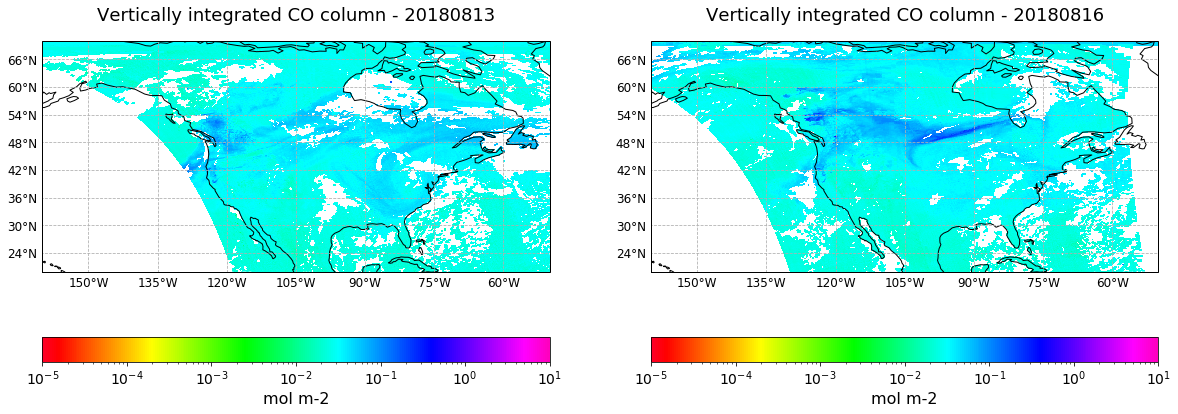

In [61]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import cartopy.crs as ccrs

fig=plt.figure(figsize=(20, 12))

################################
# Start of first subplot
################################
ax1 = plt.subplot(1,2,1, projection=ccrs.PlateCarree())

# define the coordinate system that the grid lons and grid lats are on
#img = plt.pcolormesh(lon, lat, np.squeeze(co.data), norm=LogNorm(), cmap=plt.get_cmap('jet'), transform=ccrs.PlateCarree())
img1 = plt.pcolormesh(lon_13, lat_13, np.squeeze(co_13.data), norm=LogNorm(), cmap=plt.get_cmap(color_scale), transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax)
ax1.set_extent([lonmin, lonmax, latmin, latmax], ccrs.PlateCarree())
ax1.coastlines()

gl = ax1.gridlines(draw_labels=True, linestyle='--')
gl.xlabels_top=False
gl.ylabels_right=False
gl.xformatter=LONGITUDE_FORMATTER
gl.yformatter=LATITUDE_FORMATTER
    
gl.xlabel_style={'size':12}
gl.ylabel_style={'size':12}

cbar = fig.colorbar(img1, ax=ax1, orientation='horizontal', fraction=0.04, pad=0.1)
cbar.set_label(co_13.units, fontsize=16)
cbar.ax.tick_params(labelsize=14)
ax1.set_title(co_13.long_name + ' - ' + day1, fontsize=18, pad=20.0)

################################
# Start of second subplot
################################
ax2 = plt.subplot(1,2,2, projection=ccrs.PlateCarree())

# define the coordinate system that the grid lons and grid lats are on
#img = plt.pcolormesh(lon, lat, np.squeeze(co.data), norm=LogNorm(), cmap=plt.get_cmap('jet'), transform=ccrs.PlateCarree())
img2 = plt.pcolormesh(lon_16, lat_16, np.squeeze(co_16.data), norm=LogNorm(), cmap=plt.get_cmap(color_scale), transform=ccrs.PlateCarree(),vmin=vmin, vmax=vmax)
ax2.set_extent([lonmin, lonmax, latmin, latmax], ccrs.PlateCarree())
ax2.coastlines()

gl = ax2.gridlines(draw_labels=True, linestyle='--')
gl.xlabels_top=False
gl.ylabels_right=False
gl.xformatter=LONGITUDE_FORMATTER
gl.yformatter=LATITUDE_FORMATTER
    
gl.xlabel_style={'size':12}
gl.ylabel_style={'size':12}

cbar = fig.colorbar(img2, ax=ax2, orientation='horizontal', fraction=0.04, pad=0.1)
cbar.set_label(co_16.units, fontsize=16)
cbar.ax.tick_params(labelsize=14)
ax2.set_title(co_16.long_name + ' - ' + day2, fontsize=18, pad=20.0)

plt.show()

<hr>

<p style="text-align:left;">This project is licensed under the <a href="./LICENSE">MIT License</a> <span style="float:right;"><a href="https://gitlab.eumetsat.int/eo-lab/training-atmospheric-composition/">View on GitLab</a> | <a href="https://training.eumetsat.int/">EUMETSAT Training</a> | <a href=mailto:training@eumetsat.int>Contact</a></span></p>